In [1]:
! pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

## 1. Data

### 1.1 Sample Data

In [3]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=300, shuffle=True, noise=0.5, random_state=2021)

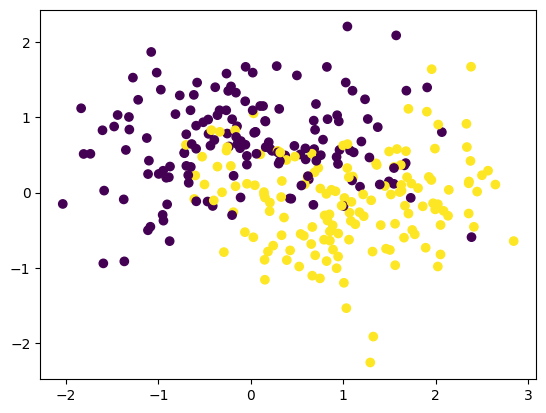

In [4]:
plt.scatter(data[:, 0], data[:, 1], c=label)

### 1.2 Resample Data

In [5]:
from imblearn.datasets import make_imbalance
from collections import Counter

def ratio_func(y, multiplier, minority_class):
  target_stats = Counter(y)
  return {minority_class: int(multiplier * target_stats[minority_class])}

data, label = make_imbalance(
    data,
    label,
    sampling_strategy=ratio_func,
    **{"multiplier": 0.1, "minority_class": 1,}
)

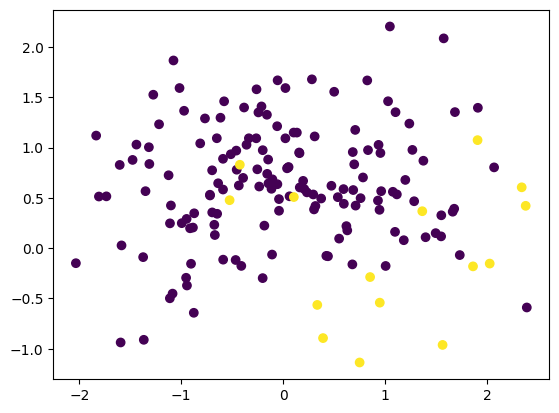

In [6]:
plt.scatter(data[:, 0], data[:, 1], c=label)

In [7]:
pd.Series(label).value_counts()

0    150
1     15
dtype: int64

### 1.3 Split Data

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(
    data, label, train_size=0.7, random_state=2021, stratify=label
)

In [9]:
train_label.mean()

0.08695652173913043

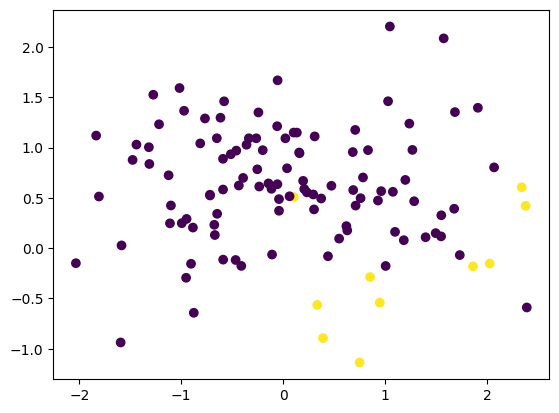

In [10]:
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_label)

In [11]:
test_label.mean()

0.1

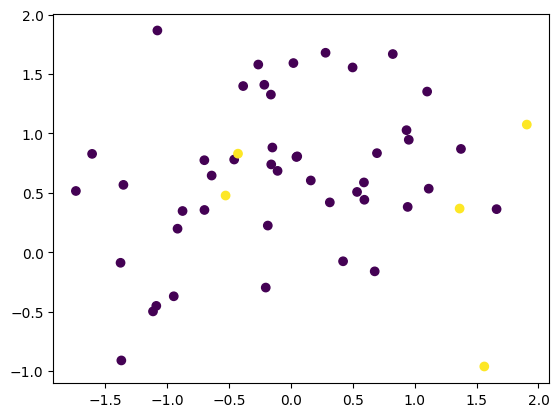

In [12]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_label)

### 1.4 시각화 데이터

In [13]:
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

## 2. Model

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

### 2.1 학습 & 예측

In [15]:
tree.fit(train_data, train_label)

DecisionTreeClassifier()

In [16]:
tree_train_pred = tree.predict(train_data)
tree_test_pred = tree.predict(test_data)

### 2.3 평가
정확도

In [17]:
from sklearn.metrics import accuracy_score

tree_train_acc = accuracy_score(train_label, tree_train_pred)
tree_test_acc = accuracy_score(test_label, tree_test_pred)

In [18]:
print(f"Tree train accuracy is {tree_train_acc:.4f}")
print(f"Tree test accuracy is {tree_test_acc:.4f}")

Tree train accuracy is 1.0000
Tree test accuracy is 0.8800


F1 score

In [19]:
from sklearn.metrics import f1_score

tree_train_f1 = f1_score(train_label, tree_train_pred)
tree_test_f1 = f1_score(test_label, tree_test_pred)

In [20]:
print(f"Tree train F1-Score is {tree_train_f1:.4f}")
print(f"Tree test F1-Score is {tree_test_f1:.4f}")

Tree train F1-Score is 1.0000
Tree test F1-Score is 0.2500


### 2.4 시각화

In [21]:
tree_Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
tree_Z = tree_Z.reshape(xx.shape)

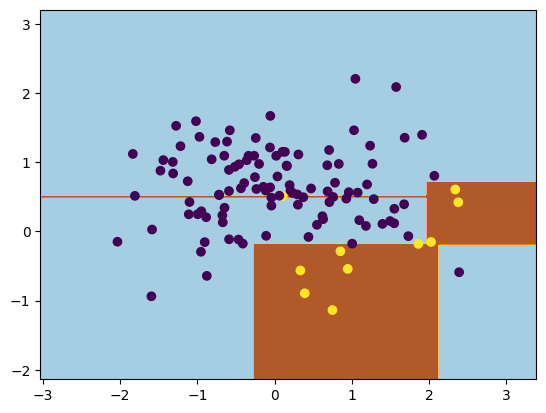

In [22]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_label)

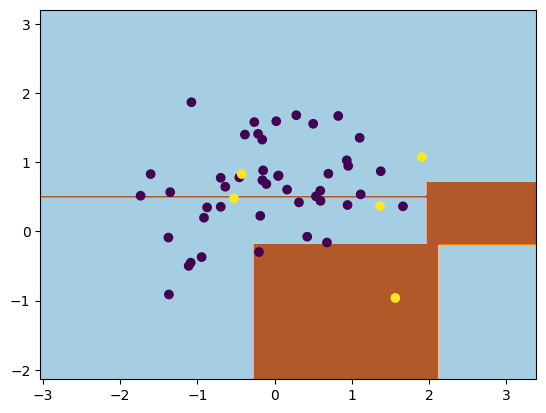

In [23]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_label)

## 3. Under Sampling

### 3.1 Under Sampling data

In [24]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

under_dict = {}

rus = RandomUnderSampler(random_state=2021)
rus_data, rus_label = rus.fit_resample(train_data, train_label)
under_dict["rus"] = {"data": rus_data, "label": rus_label}

In [25]:
for i in range(1, 4):
  near_miss = NearMiss(version=i)
  near_data, near_label = near_miss.fit_resample(train_data, train_label)
  under_dict[f"near_{i}"] = {
      "data": near_data, "label": near_label
  }

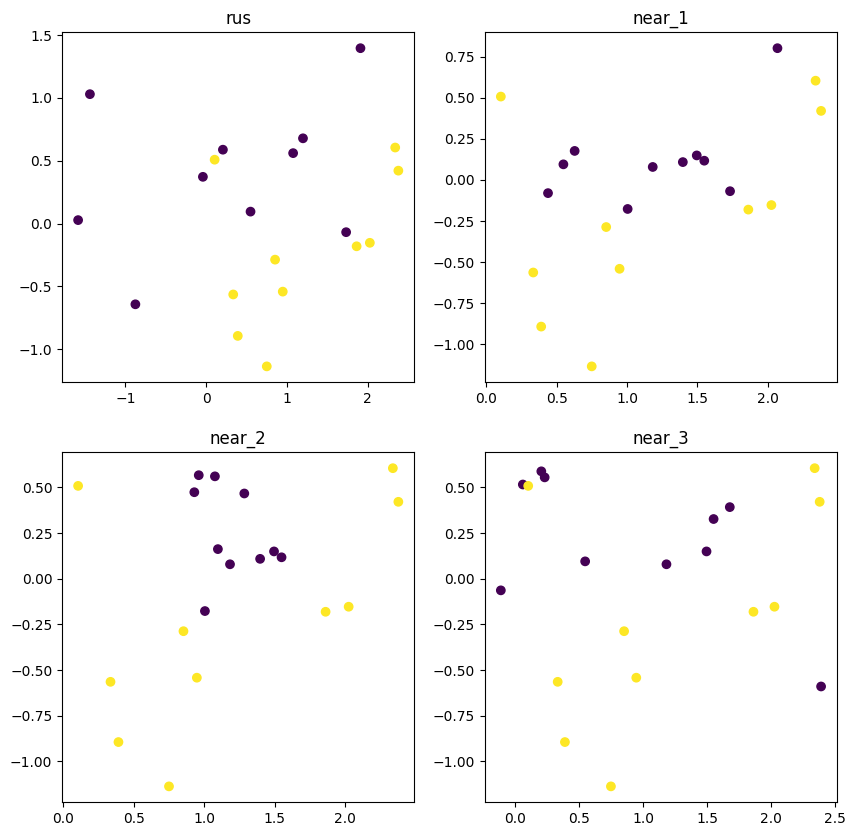

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, sample) in enumerate(under_dict.items()):
  ax = axes[idx//2, idx%2]
  d, l = sample["data"], sample["label"]
  ax.scatter(d[:, 0], d[:, 1], c=l)
  ax.set_title(name)

### 3.2 학습

In [27]:
under_model = {}

for name, sample in under_dict.items():
  under_tree = DecisionTreeClassifier()
  under_tree.fit(sample["data"], sample["label"])
  under_model[name] = under_tree

In [28]:
under_model

{'rus': DecisionTreeClassifier(),
 'near_1': DecisionTreeClassifier(),
 'near_2': DecisionTreeClassifier(),
 'near_3': DecisionTreeClassifier()}

### 3.3 예측

In [29]:
under_pred = {}
for name, under_tree in under_model.items():
  under_test_pred = under_tree.predict(test_data)
  under_pred[name] = under_test_pred

In [30]:
under_pred

{'rus': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 'near_1': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 'near_2': array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1]),
 'near_3': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])}

### 3.4 평가

정확도

In [31]:
for name, pred in under_pred.items():
  acc = accuracy_score(test_label, pred)
  print(f"{name} Sampling test accuracy is {acc:.4f}")

rus Sampling test accuracy is 0.8400
near_1 Sampling test accuracy is 0.1800
near_2 Sampling test accuracy is 0.3400
near_3 Sampling test accuracy is 0.8000


F1-Score

In [32]:
for name, pred in under_pred.items():
  f1 = f1_score(test_label, pred)
  print(f"{name} Sampling test F1-Score is {f1:.4f}")

rus Sampling test F1-Score is 0.2000
near_1 Sampling test F1-Score is 0.1633
near_2 Sampling test F1-Score is 0.1951
near_3 Sampling test F1-Score is 0.1667


### 3.5 시각화  
Train Data

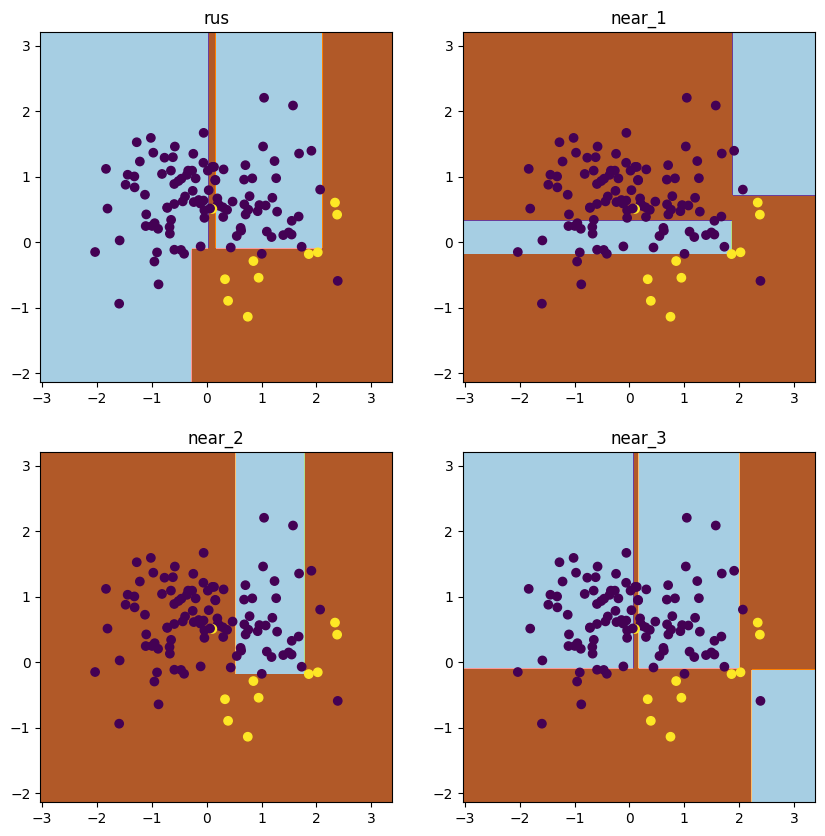

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
  ax = axes[idx//2, idx%2]
  under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
  under_Z = under_Z.reshape(xx.shape)
  ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
  ax.scatter(train_data[:, 0], train_data[:, 1], c=train_label)
  ax.set_title(name)

Test Data

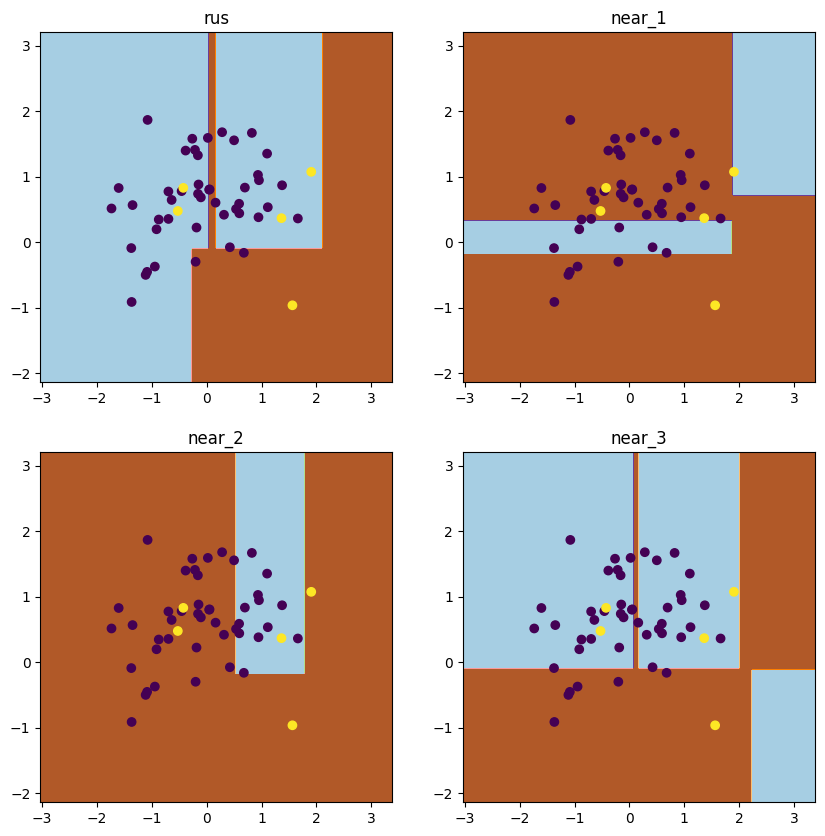

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
  ax = axes[idx//2, idx%2]
  under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
  under_Z = under_Z.reshape(xx.shape)
  ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
  ax.scatter(test_data[:, 0], test_data[:, 1], c=test_label)
  ax.set_title(name)

## 4. OverSampling

### 4.1 Over sampling data

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2021)

In [36]:
smote_data, smote_label = smote.fit_resample(train_data, train_label)

In [37]:
smote_data[:10]

array([[ 1.0963906 ,  0.16215513],
       [ 0.43879078, -0.0803489 ],
       [ 0.20618849,  0.58791678],
       [-0.59047253,  0.58307246],
       [ 1.73131008, -0.06861231],
       [ 0.10237896,  1.1495802 ],
       [ 0.23230422,  0.55483897],
       [-1.1107737 ,  0.24678492],
       [ 0.94696029, -0.54173336],
       [-0.87710056, -0.64256821]])

In [38]:
smote_label[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

Text(0.5, 1.0, 'smote data')

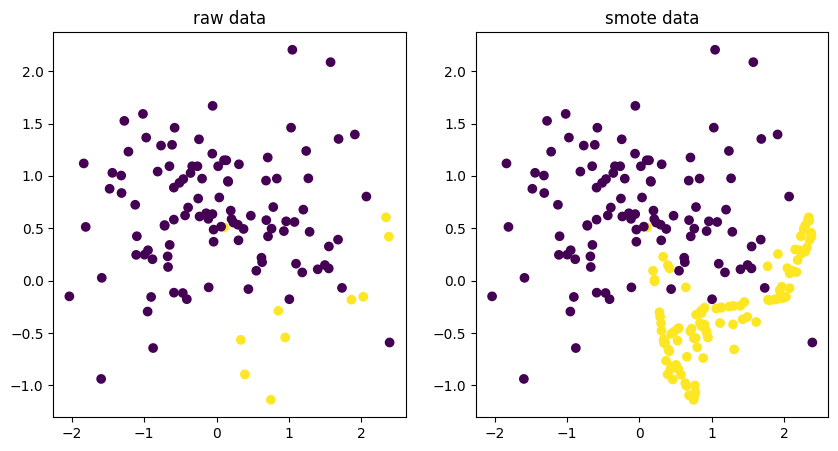

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].scatter(train_data[:, 0], train_data[:, 1], c=train_label)
axes[0].set_title("raw data")

axes[1].scatter(smote_data[:, 0], smote_data[:, 1], c=smote_label)
axes[1].set_title("smote data")

### 4.2 학습

In [41]:
smote_tree = DecisionTreeClassifier()
smote_tree.fit(smote_data, smote_label)

DecisionTreeClassifier()

### 4.3 예측

In [42]:
smote_test_pred = smote_tree.predict(test_data)

### 4.4 평가
정확도

In [43]:
smote_acc = accuracy_score(test_label, smote_test_pred)
print(f"SMOTE test accuracy is {smote_acc:.4f}")

SMOTE test accuracy is 0.9000


In [49]:
smote_f1 = f1_score(test_label, smote_test_pred)
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

SMOTE test F1-Score is 0.2857


### 4.5 시각화

In [44]:
smote_Z = smote_tree.predict(np.c_[xx.ravel(), yy.ravel()])
smote_Z = smote_Z.reshape(xx.shape)

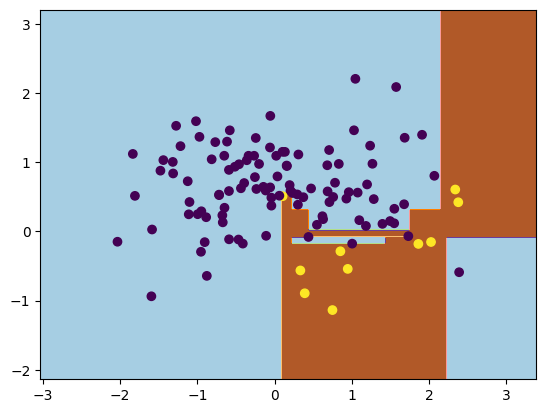

In [45]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)

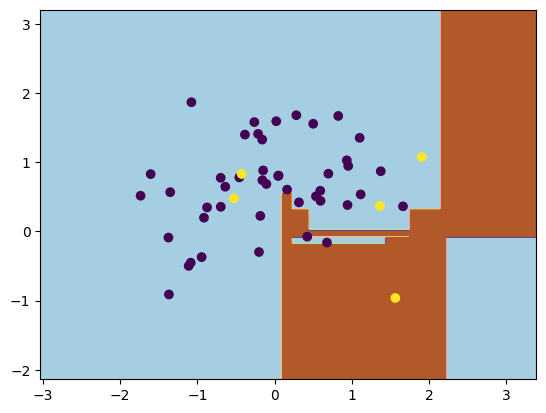

In [46]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:,0], test_data[:,1], c=test_label)

## 5. 마무리
### 5.1 정확도

In [47]:
print(f"Tree test accuracy is {tree_test_acc:.4f}")
for name, pred in under_pred.items():
  acc = accuracy_score(test_label, pred)
  print(f"{name} Sampling test accuracy in {acc:.4f}")
print(f"SMOTE test accuracy is {smote_acc:.4f}")

Tree test accuracy is 0.8800
rus Sampling test accuracy in 0.8400
near_1 Sampling test accuracy in 0.1800
near_2 Sampling test accuracy in 0.3400
near_3 Sampling test accuracy in 0.8000
SMOTE test accuracy is 0.9000


### 5.2 F1 Score

In [50]:
print(f"Tree test F1-Score is {tree_test_acc:.4f}")
for name, pred in under_pred.items():
  f1 = f1_score(test_label, pred)
  print(f"{name} Sampling test F1-Score in {f1:.4f}")
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

Tree test F1-Score is 0.8800
rus Sampling test F1-Score in 0.2000
near_1 Sampling test F1-Score in 0.1633
near_2 Sampling test F1-Score in 0.1951
near_3 Sampling test F1-Score in 0.1667
SMOTE test F1-Score is 0.2857
